# Big Data Bowl 2022: Special Teams Plays' Excitement Ratings

In this notebook, I'll try to create an excitement metric that will have a pre-snap prediction of "expected excitement", an in-play excitement meter, and an overall excitement score for each special teams play. 

## A Few Notes
- Pre snap excitement would probably just be some linear combination of game-level data
- In play excitement, could take tracking data along with game-level data in order to provide live adjustments to excitement
    - We'd need some way of storing excitement over time
- How is final excitement determined?
    - Is it just game level data again or can the in play tracking data affect the final score?

## Plan of Attack
1. Learn, clean, and manipulate the game, play, player, tracking, and scouting data
1. Split into test/train
1. Create a simple baseline metric to score each play in train data set
    1. This is probably just going to be game-level data
    1. We'll call this the overall excitement score
1. Train a model to predict overall excitement scores using only pre-snap (ie frame1) data
1. Use this model to predict excitement scores pre-snap on the test set
1. Analyze results to determine how good the model is
1. Create more complex excitement score based on player, team, game, play data
1. Rinse and repeat


In [1]:
import math
import time
import pandas as pd
import numpy as np
import seaborn as sn
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from matplotlib.animation import FuncAnimation
from matplotlib import patches
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.metrics import ConfusionMatrixDisplay

np.set_printoptions(suppress=True)

## Constants

In [2]:
field_height = 53.3
field_length = 120
endzone_length = 10
seconds_in_a_half = 15 * 60
seconds_in_overtime = 10 * 60

## Import and Inspect Game Data

In [3]:
games = pd.read_csv('data/games.csv')
games.head()

,gameId,season,week,gameDate,gameTimeEastern,homeTeamAbbr,visitorTeamAbbr
0,2018090600,2018,1,09/06/2018,20:20:00,PHI,ATL
1,2018090900,2018,1,09/09/2018,13:00:00,BAL,BUF
2,2018090901,2018,1,09/09/2018,13:00:00,CLE,PIT
3,2018090902,2018,1,09/09/2018,13:00:00,IND,CIN
4,2018090903,2018,1,09/09/2018,13:00:00,MIA,TEN


## Import and Inspect Player Data

In [4]:
players = pd.read_csv('data/players.csv')
players.head()

,nflId,height,weight,birthDate,collegeName,Position,displayName
0,42901,6-1,208,1992-07-25,James Madison,SS,Dean Marlowe
1,43501,6-0,220,1994-08-11,Central Michigan,FS,Kavon Frazier
2,43534,6-0,205,1993-06-02,Illinois,SS,Clayton Fejedelem
3,43535,6-1,235,1992-12-22,Temple,MLB,Tyler Matakevich
4,44174,6-1,236,1993-02-22,Texas Tech,ILB,Sam Eguavoen


## Import and Inspect Play Data

In [5]:
plays = pd.read_csv('data/plays.csv')
plays.head()

,gameId,playId,playDescription,quarter,down,yardsToGo,possessionTeam,specialTeamsPlayType,specialTeamsResult,kickerId,...,penaltyCodes,penaltyJerseyNumbers,penaltyYards,preSnapHomeScore,preSnapVisitorScore,passResult,kickLength,kickReturnYardage,playResult,absoluteYardlineNumber
0,2018090600,37,J.Elliott kicks 65 yards from PHI 35 to end zo...,1,0,0,PHI,Kickoff,Touchback,44966.0,...,NaN,NaN,NaN,0,0,NaN,66.0,NaN,40,45
1,2018090600,366,"(9:20) C.Johnston punts 56 yards to ATL 36, Ce...",1,4,4,PHI,Punt,Return,45603.0,...,UNSd,PHI 18,-15.0,0,0,NaN,56.0,5.0,36,18
2,2018090600,658,"(5:03) M.Bryant 21 yard field goal is GOOD, Ce...",1,4,3,ATL,Field Goal,Kick Attempt Good,27091.0,...,NaN,NaN,NaN,0,0,NaN,21.0,NaN,0,13
3,2018090600,677,M.Bosher kicks 64 yards from ATL 35 to PHI 1. ...,1,0,0,ATL,Kickoff,Return,37267.0,...,NaN,NaN,NaN,0,3,NaN,64.0,30.0,34,75
4,2018090600,872,"(:33) C.Johnston punts 65 yards to end zone, C...",1,4,18,PHI,Punt,Touchback,45603.0,...,NaN,NaN,NaN,0,3,NaN,65.0,NaN,45,45


## Merge Game and Play Data

We want to be able to access game data at a play level primarily when we look at tracking data. we'll also add a field to indicate who is on offense (**home** or **away**).

In [6]:
plays = plays.merge(games, on='gameId')
plays['is_home_offense'] = plays['possessionTeam'] == plays['homeTeamAbbr']
plays.head()

,gameId,playId,playDescription,quarter,down,yardsToGo,possessionTeam,specialTeamsPlayType,specialTeamsResult,kickerId,...,kickReturnYardage,playResult,absoluteYardlineNumber,season,week,gameDate,gameTimeEastern,homeTeamAbbr,visitorTeamAbbr,is_home_offense
0,2018090600,37,J.Elliott kicks 65 yards from PHI 35 to end zo...,1,0,0,PHI,Kickoff,Touchback,44966.0,...,NaN,40,45,2018,1,09/06/2018,20:20:00,PHI,ATL,True
1,2018090600,366,"(9:20) C.Johnston punts 56 yards to ATL 36, Ce...",1,4,4,PHI,Punt,Return,45603.0,...,5.0,36,18,2018,1,09/06/2018,20:20:00,PHI,ATL,True
2,2018090600,658,"(5:03) M.Bryant 21 yard field goal is GOOD, Ce...",1,4,3,ATL,Field Goal,Kick Attempt Good,27091.0,...,NaN,0,13,2018,1,09/06/2018,20:20:00,PHI,ATL,False
3,2018090600,677,M.Bosher kicks 64 yards from ATL 35 to PHI 1. ...,1,0,0,ATL,Kickoff,Return,37267.0,...,30.0,34,75,2018,1,09/06/2018,20:20:00,PHI,ATL,False
4,2018090600,872,"(:33) C.Johnston punts 65 yards to end zone, C...",1,4,18,PHI,Punt,Touchback,45603.0,...,NaN,45,45,2018,1,09/06/2018,20:20:00,PHI,ATL,True


## Import and Inspect Scouting Data

In [7]:
scout = pd.read_csv('data/PFFScoutingData.csv')
scout.head()

,gameId,playId,snapDetail,snapTime,operationTime,hangTime,kickType,kickDirectionIntended,kickDirectionActual,returnDirectionIntended,returnDirectionActual,missedTackler,assistTackler,tackler,kickoffReturnFormation,gunners,puntRushers,specialTeamsSafeties,vises,kickContactType
0,2018090600,37,NaN,NaN,NaN,3.85,D,R,R,NaN,NaN,NaN,NaN,NaN,8-0-2,NaN,NaN,PHI 23; PHI 27,NaN,NaN
1,2018090600,366,OK,0.84,2.12,4.46,N,C,C,C,R,PHI 57,NaN,PHI 54,NaN,PHI 18; PHI 29,NaN,NaN,ATL 83; ATL 27; ATL 34; ATL 21,CC
2,2018090600,658,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,PHI 58,NaN,NaN
3,2018090600,677,NaN,NaN,NaN,4.06,D,R,R,C,C,ATL 83,ATL 22,ATL 27,8-0-2,NaN,NaN,ATL 17; ATL 22,NaN,NaN
4,2018090600,872,OK,0.84,2.00,4.35,N,C,L,NaN,NaN,NaN,NaN,NaN,NaN,PHI 18; PHI 29,ATL 85,ATL 37,ATL 83; ATL 34; ATL 21,BF


## Import and Inspect Tracking Data

In [8]:
tracking_2018 = pd.read_csv('data/tracking2018.csv')
tracking_2019 = pd.read_csv('data/tracking2019.csv')
tracking_2020 = pd.read_csv('data/tracking2020.csv')

Merging the tracking data can take a few minutes.

In [9]:
tracking = tracking_2018.append([tracking_2019, tracking_2020])
tracking.head()

,time,x,y,s,a,dis,o,dir,event,nflId,displayName,jerseyNumber,position,team,frameId,gameId,playId,playDirection
0,2018-12-30T21:25:32.200,41.32,29.45,4.36,1.33,0.43,130.42,128.44,None,39470.0,Justin Tucker,9.0,K,home,1,2018123000,36,right
1,2018-12-30T21:25:32.300,41.68,29.17,4.59,1.24,0.45,128.59,127.81,None,39470.0,Justin Tucker,9.0,K,home,2,2018123000,36,right
2,2018-12-30T21:25:32.400,42.05,28.88,4.74,0.99,0.47,124.47,128.15,None,39470.0,Justin Tucker,9.0,K,home,3,2018123000,36,right
3,2018-12-30T21:25:32.500,42.43,28.59,4.87,0.71,0.48,126.02,127.35,None,39470.0,Justin Tucker,9.0,K,home,4,2018123000,36,right
4,2018-12-30T21:25:32.600,42.84,28.31,4.96,0.79,0.50,131.71,124.75,None,39470.0,Justin Tucker,9.0,K,home,5,2018123000,36,right


## Enrich Tracking Data

In order to be consistent, let's standardize the play direction to always have the offense going from *left* to *right*. All we should need to do is for plays going to the *left*,
- flip x coordinate (`field_width - x`), 
- flip y coordinate (`field_height - y`), and 
- rotate the dir by 180 (`(360 - dir) % 360`). 

For plays going to the *right*, no conversion is needed. We'll store these new, or "standardized", values in `stdX`, `stdY`, and `stdDir`.

We'll also convert cartesian to polar coordinates for later on.

In [10]:
left_mask = tracking['playDirection'] == 'left'
right_mask = tracking['playDirection'] == 'right'
tracking.loc[left_mask, 'stdX'] = 120 - tracking.loc[left_mask, 'x']
tracking.loc[left_mask, 'stdY'] = field_height - tracking.loc[left_mask, 'y']
tracking.loc[left_mask, 'stdDir'] = (360 - tracking.loc[left_mask, 'dir']) % 360
tracking.loc[right_mask, 'stdX'] = tracking.loc[right_mask, 'x']
tracking.loc[right_mask, 'stdY'] = tracking.loc[right_mask, 'y']
tracking.loc[right_mask, 'stdDir'] = tracking.loc[right_mask, 'dir']
tracking['stdR'] = (tracking['stdX'].pow(2) + tracking['stdY'].pow(2)).pow(1/2)
tracking['stdTheta'] = np.arctan(tracking['stdY']/tracking['stdX'])
tracking.head()

,time,x,y,s,a,dis,o,dir,event,nflId,...,team,frameId,gameId,playId,playDirection,stdX,stdY,stdDir,stdR,stdTheta
0,2018-12-30T21:25:32.200,41.32,29.45,4.36,1.33,0.43,130.42,128.44,None,39470.0,...,home,1,2018123000,36,right,41.32,29.45,128.44,50.740959,0.619219
1,2018-12-30T21:25:32.300,41.68,29.17,4.59,1.24,0.45,128.59,127.81,None,39470.0,...,home,2,2018123000,36,right,41.68,29.17,127.81,50.873483,0.610629
2,2018-12-30T21:25:32.400,42.05,28.88,4.74,0.99,0.47,124.47,128.15,None,39470.0,...,home,3,2018123000,36,right,42.05,28.88,128.15,51.012321,0.601813
3,2018-12-30T21:25:32.500,42.43,28.59,4.87,0.71,0.48,126.02,127.35,None,39470.0,...,home,4,2018123000,36,right,42.43,28.59,127.35,51.163395,0.592936
4,2018-12-30T21:25:32.600,42.84,28.31,4.96,0.79,0.50,131.71,124.75,None,39470.0,...,home,5,2018123000,36,right,42.84,28.31,124.75,51.349018,0.583952


## Visualize Plays

One helpful thing when working with tracking data is to be able to see what each datapoint represents and how a frame looks. 
To do that, we'll create a function that creates a GIF of the requested play.
It'll take in a `game_id`, `play_id`, and Boolean flag `std` which says if the GIF should use the standardized coordinates or not. 

In [77]:
def animate_play(game_id, play_id, std=False):
    x_name = 'stdX' if std else 'x'
    y_name = 'stdY' if std else 'y'

    play = tracking.loc[(tracking['gameId'] == game_id) &( tracking['playId'] == play_id)]

    print(f'Found {len(play.index)} Frames for game {game_id} play {play_id}')

    play['nflId'] = play['nflId'].fillna('football').astype(str)
    play['marker'] = play['team'].replace({'home': 'o', 'away': 's', 'football': 'd'})
    play['color'] = play['team'].replace({'home': 'r', 'away': 'blue', 'football': 'brown'})

    fig, ax = draw_field()
    markers = {
        f'{x["nflId"]}': ax.scatter(
            x[x_name], 
            x[y_name],
            s=10,
            marker=x['marker'],
            c=x['color'],
            zorder=3,
            edgecolors='black'
        ) for x in play.loc[play["frameId"] == 1].to_dict(orient='records')
    }
    frame_text = ax.text(0, 5, '1')

    def update(i):
        new_values = play.loc[play["frameId"] == i].set_index('nflId')[[x_name, y_name]].to_dict(orient='index')
        frame_text.set_text(i)
        for k, v in markers.items():
            v.set_offsets([new_values[k][x_name], new_values[k][y_name]])
        return *markers.values(), frame_text

    ani = FuncAnimation(fig, update, frames=play['frameId'].unique(), blit=True)
    ani.save(f'game-{game_id}_play-{play_id}{"-std" if std else ""}.gif')

def draw_field():
    fig = plt.figure() 
    ax = plt.axes(xlim=(0, 120), ylim=(0, field_height)) 
    ax.set_facecolor('green')

    # Endzones
    rect = patches.Rectangle((0, 0), endzone_length, field_height, linewidth=1, edgecolor='r', facecolor='red', zorder=1)
    ax.add_patch(rect)
    rect = patches.Rectangle((field_length - endzone_length, 0), endzone_length, field_height, linewidth=1, edgecolor='blue', facecolor='blue', zorder=1)
    ax.add_patch(rect)

    # Yardlines
    for i in range(12):
        ax.plot((i*10, i*10), (0, field_height), color='w', zorder=1)
        if 1 < i < 11:
            label = (i-1) * 10
            ax.text(i*10 - 3, 5, f'{label}' if i < 6 else f'{100 - label}')

    plt.tick_params(
        axis='both', 
        which='both', 
        bottom=False, 
        top=False,       
        left=False,
        labelbottom=False,
        labelleft=False
    ) 
    return fig, ax


Let's try out this function with a play that's going to the *left* so we can see if the standardized coordinates worked as well. The first function call will create a file `game-2018090600_play-658-std.gif` and the second call will create `game-2018090600_play-658.gif`.

Found 1058 Frames for game 2018090600 play 658


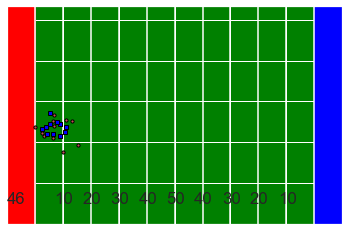

In [78]:
# animate_play(2018090600, 658, True)
# animate_play(2018090600, 658)

## Brain Dump on What Makes a Good Special Teams Play

> This is just some notes I didn't know where to put, but wanted to jot down
> 
>Something to keep in mind when considering excitement for plays is that you can't "pick a side", so defensive plays are as exciting as offensive plays. For example, if your punt got blocked, that's the opposite of exciting for you, but near-max excitement for the other team, which makes the play near-max exciting.

> It may also be interesting to try to have 3 different excitement metrics:
> - Home team
> - Away team
> - Game (this would probably just be the sum/max of home team and away team's excitement)

Before we consider specific types of special teams plays, there are some general attributes of any football game that contribute to excitement:
- Teams
    - Rivalries are exciting \[`is_rivalry`\]
    - Underdogs are exciting \[???\]
    - Game type (preseason, regular season, post season) are exciting \[`week`?\]
- Score of the game
    - Close games are exciting (usually more so for the underdog) \[`preSnapHomeScore`, `preSnapAwayScore`\]
    - Underdog wins are exciting \[???]\
    - Blowouts are generally less exciting \[scores again\]
    - Number of possessions in point differential are exciting (eg "if this field goal is good, it's a 1 posession game") \[scores and `specialTeamsPlayType`\]
- Time Left in the Game 
    - This usually is dependent on the score \[`gameClock`, `quarter`\]
    - Beginning of the game is almost always exciting \[`gameClock`, `quarter`\]
    - Overtime is exciting \[`quarter`\]
- The Unusual or Unexpected
    - Most of the time there is a clear "safe" option and a clear "risky" option. Risky is more exciting. \[`yardsToGo`, `score`, `yardLine`, `quarter`\]
    - Extreme plays are unusual (eg long field goals, long kickoff/punt returns, blocks, fumbles)
        - We'll discuss this more when we look at each type of play
    - Trick/Fake plays are exciting
    - Unusually long or short plays are exciting \[`numberOfFrames`, `operationTime`, `gameClock`\]
- Location of the Ball
    - Red zone possessions are exciting \[`yardline`\]
    - Pinning opponents in/close to their endzone is exciting \[`playResult`, `kickReturnYardage`\]

Now, with the above excitement factors in mind, let's break down each of the 4 types of Special Teams plays:

1. **Extra Point**
When are extra points exciting?
        
    - Generally 2 points are more exciting than 1
    - Longer or shorter than normal
    - A fake field goal
    - Good defensive play
        - Blocked PAT
        - Stopped 2pt conversion

1. **Field Goal**
When are field goals exciting?

    - Longer or shorter than normal
    - A fake
    - Fumble
    - Good defensive play
        - Block
        - Fumble recovery
        - Return on a fg

1. **Kickoff**
When is a kickoff exciting?

    - Long return
    - Botched/fumbled catch
    - Fair catches are not too exciting
    - When there is an onside kick
    - First play of the game/half/OT
    
1. **Punt**
When is a punt exciting?

    - Fake
    - Long/short punt
    - Leaves the defense inside 5/10
    - When it's a good defensive play
        - A block
        - A long return
        - A turnover on downs
    - Penalties that cause punting team to retain possesion

## Investigate Play Data to Try to Identify Exciting Plays

One main theme that appeared in theoretically exciting plays is unusual or unexpected plays. We'll try to find those by looking at outliers results of plays. To start, we'll count all the results for each special teams play types and then we'll analyze those results.

In [13]:
# How to heatmap df
# df.style.background_gradient(cmap='Blues')

In [14]:
num_games = plays['gameId'].unique().size

In [15]:
# To get an idea of the number of each play type per game
plays.groupby('specialTeamsPlayType').size().divide(num_games)

specialTeamsPlayType
Extra Point     4.565445
Field Goal      3.477749
Kickoff        10.265707
Punt            7.841623
dtype: float64

In [16]:
play_results = plays.groupby(['specialTeamsPlayType', 'specialTeamsResult']).size().unstack('specialTeamsPlayType')
play_results

specialTeamsPlayType,Extra Point,Field Goal,Kickoff,Punt
specialTeamsResult,,,,
Blocked Kick Attempt,24.0,37.0,NaN,NaN
Blocked Punt,NaN,NaN,NaN,39.0
Downed,NaN,1.0,4.0,829.0
Fair Catch,NaN,NaN,5.0,1640.0
Kick Attempt Good,3252.0,2218.0,NaN,NaN
Kick Attempt No Good,199.0,386.0,NaN,NaN
Kickoff Team Recovery,NaN,NaN,16.0,NaN
Muffed,NaN,NaN,60.0,154.0
Non-Special Teams Result,13.0,14.0,NaN,74.0


This data frame shows the number of times each result happens for each type of play for all the games in the dataset. We don't want to replace these NaN's with 0 because each play type only has a specific subset of the possible outcomes, so some outcomes cannot happen in certain scenarios. A 0 would indicate that outcome is possible, but it hasn't happened (which is important in our case because something that hasn't happened in 3 years would be very exciting).

Next, let's look at how many times each result happens per game.

In [17]:
play_results = play_results.divide(num_games)
play_results.style.background_gradient(cmap='Blues')

specialTeamsPlayType,Extra Point,Field Goal,Kickoff,Punt
specialTeamsResult,,,,
Blocked Kick Attempt,0.031414,0.048429,nan,nan
Blocked Punt,nan,nan,nan,0.051047
Downed,nan,0.001309,0.005236,1.085079
Fair Catch,nan,nan,0.006545,2.146597
Kick Attempt Good,4.256545,2.903141,nan,nan
Kick Attempt No Good,0.260471,0.505236,nan,nan
Kickoff Team Recovery,nan,nan,0.020942,nan
Muffed,nan,nan,0.078534,0.201571
Non-Special Teams Result,0.017016,0.018325,nan,0.096859


Another way of interpreting the above data frame is to consider its element-wise inverse, which shows how many games it takes for that outcome to happen.

In [18]:
play_results.pow(-1)

specialTeamsPlayType,Extra Point,Field Goal,Kickoff,Punt
specialTeamsResult,,,,
Blocked Kick Attempt,31.833333,20.648649,NaN,NaN
Blocked Punt,NaN,NaN,NaN,19.589744
Downed,NaN,764.000000,191.000000,0.921592
Fair Catch,NaN,NaN,152.800000,0.465854
Kick Attempt Good,0.234932,0.344454,NaN,NaN
Kick Attempt No Good,3.839196,1.979275,NaN,NaN
Kickoff Team Recovery,NaN,NaN,47.750000,NaN
Muffed,NaN,NaN,12.733333,4.961039
Non-Special Teams Result,58.769231,54.571429,NaN,10.324324


Selecting a few points from the previous data frames we can try to find some exciting scenarios:
- For a **Field Goal**, getting **Downed** or **Out of Bounds** is very uncommon and each outcome is expected to happen only once every 764 games!
- Getting a **Touchback** on a **Kick Off** is almost guaranteed to happen since you can expect around 6 **Touchbacks** per game

These two data frames can represent excitement based on how likely a play result is expected to happen. In the first frame,lower numbers represent less frequent outcomes, however in the latter, high numbers represent less frequent outcomes.

Another useful thing to understand is the distribution of outcomes for each play type. 

> *Note: pandas' pie plots out of the box aren't so great, but we can basically accomplish the same thing using bars.* 

So let's take a look:

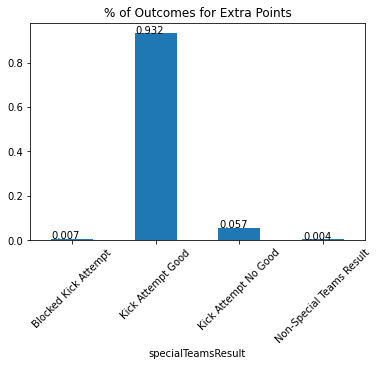

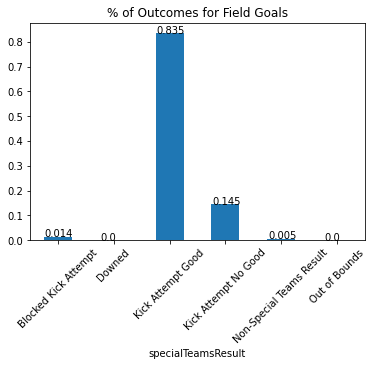

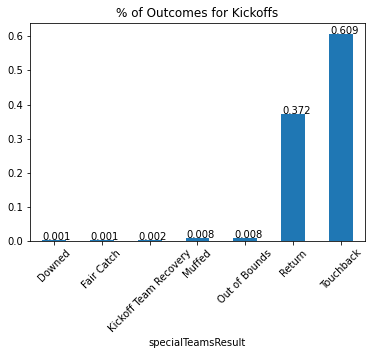

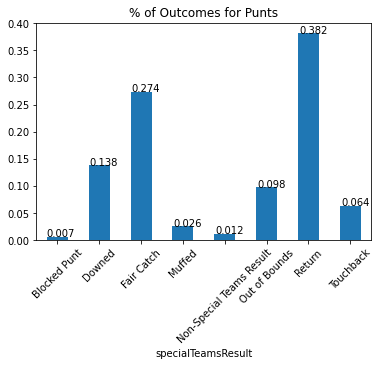

In [19]:
for play_type in play_results.columns:
    # Remove NA values and normalize each column before plotting it
    normalized_results = play_results[play_type].dropna().divide(play_results[play_type].sum())
    ax = normalized_results.plot.bar(title=f'% of Outcomes for {play_type}s', rot=45)
    
    # Label each bar
    for p in ax.patches:
        ax.annotate(str(round(p.get_height(), 3)), (p.get_x() * 1.005, p.get_height()))
    plt.show()

For the first, most basic, excitement metric, we'll rate the play only on how often the result happens for the play type. So the formula will be:

```excitement_score = 1 - p```

where `p` is the probability of that `specialTeamsResult` for the `specialTeamsPlayType`.

Let's add the `excitement_score_v1` to the plays df.

In [20]:
play_results_probs = play_results.div(play_results.sum(axis=0), axis=1)
play_results_probs

specialTeamsPlayType,Extra Point,Field Goal,Kickoff,Punt
specialTeamsResult,,,,
Blocked Kick Attempt,0.006881,0.013925,NaN,NaN
Blocked Punt,NaN,NaN,NaN,0.006510
Downed,NaN,0.000376,0.000510,0.138374
Fair Catch,NaN,NaN,0.000638,0.273744
Kick Attempt Good,0.932339,0.834776,NaN,NaN
Kick Attempt No Good,0.057053,0.145277,NaN,NaN
Kickoff Team Recovery,NaN,NaN,0.002040,NaN
Muffed,NaN,NaN,0.007650,0.025705
Non-Special Teams Result,0.003727,0.005269,NaN,0.012352


In [21]:
excitement_scores = play_results_probs.subtract(1).multiply(-1).unstack().dropna().rename('excitement_score_v1').to_frame()
excitement_scores

excitement_score_v1
specialTeamsPlayType specialTeamsResult                           
Extra Point          Blocked Kick Attempt                 0.993119
                     Kick Attempt Good                    0.067661
                     Kick Attempt No Good                 0.942947
                     Non-Special Teams Result             0.996273
Field Goal           Blocked Kick Attempt                 0.986075
                     Downed                               0.999624
                     Kick Attempt Good                    0.165224
                     Kick Attempt No Good                 0.854723
                     Non-Special Teams Result             0.994731
                     Out of Bounds                        0.999624
Kickoff              Downed                               0.999490
                     Fair Catch                           0.999362
                     Kickoff Team Recovery                0.997960
                     Muffed                               0.992350
                     Out of Bounds                        0.991840
                     Return                               0.627566
                     Touchback                            0.391432
Punt                 Blocked Punt                         0.993490
                     Downed                               0.861626
                     Fair Catch                           0.726256
                     Muffed                               0.974295
                     Non-Special Teams Result             0.987648
                     Out of Bounds                        0.902187
                     Return                               0.618428
                     Touchback                            0.936071

The above frame shows the excitement score for each possible outcome for each play type. Now we just have to add these scores to our `plays` data.

In [22]:
plays = plays.join(excitement_scores, on=['specialTeamsPlayType', 'specialTeamsResult'])
plays.head()

,gameId,playId,playDescription,quarter,down,yardsToGo,possessionTeam,specialTeamsPlayType,specialTeamsResult,kickerId,...,playResult,absoluteYardlineNumber,season,week,gameDate,gameTimeEastern,homeTeamAbbr,visitorTeamAbbr,is_home_offense,excitement_score_v1
0,2018090600,37,J.Elliott kicks 65 yards from PHI 35 to end zo...,1,0,0,PHI,Kickoff,Touchback,44966.0,...,40,45,2018,1,09/06/2018,20:20:00,PHI,ATL,True,0.391432
1,2018090600,366,"(9:20) C.Johnston punts 56 yards to ATL 36, Ce...",1,4,4,PHI,Punt,Return,45603.0,...,36,18,2018,1,09/06/2018,20:20:00,PHI,ATL,True,0.618428
2,2018090600,658,"(5:03) M.Bryant 21 yard field goal is GOOD, Ce...",1,4,3,ATL,Field Goal,Kick Attempt Good,27091.0,...,0,13,2018,1,09/06/2018,20:20:00,PHI,ATL,False,0.165224
3,2018090600,677,M.Bosher kicks 64 yards from ATL 35 to PHI 1. ...,1,0,0,ATL,Kickoff,Return,37267.0,...,34,75,2018,1,09/06/2018,20:20:00,PHI,ATL,False,0.627566
4,2018090600,872,"(:33) C.Johnston punts 65 yards to end zone, C...",1,4,18,PHI,Punt,Touchback,45603.0,...,45,45,2018,1,09/06/2018,20:20:00,PHI,ATL,True,0.936071


Just to attempt to get a gauge at how well this v1 score works, let's animate the top 3 most exciting plays.

In [23]:
top_3_plays = plays.sort_values('excitement_score_v1', ascending=False).head(3)
top_3_plays

,gameId,playId,playDescription,quarter,down,yardsToGo,possessionTeam,specialTeamsPlayType,specialTeamsResult,kickerId,...,playResult,absoluteYardlineNumber,season,week,gameDate,gameTimeEastern,homeTeamAbbr,visitorTeamAbbr,is_home_offense,excitement_score_v1
16871,2020111501,1451,(4:30) (Field Goal formation) K.Fairbairn punt...,2,4,13,HOU,Field Goal,Downed,43846.0,...,26,40,2020,10,11/15/2020,13:00:00,CLE,HOU,False,0.999624
12556,2019122100,751,(4:45) (Field Goal formation) K.Fairbairn punt...,1,4,7,HOU,Field Goal,Out of Bounds,43846.0,...,26,46,2019,16,12/21/2019,13:00:00,TB,HOU,False,0.999624
11190,2019112408,3173,J.Lambo kicks onside 5 yards from JAX 35 to JA...,4,0,0,JAX,Kickoff,Downed,43068.0,...,5,75,2019,12,11/24/2019,16:05:00,TEN,JAX,False,0.999490


In [24]:
cols = ['gameId', 'playId', 'excitement_score_v1', 'specialTeamsPlayType', 'specialTeamsResult']
for game_id, play_id, ex, play_type, result in top_3_plays[cols].values:
    print(f'Game: {game_id}; Play: {play_id}; Excitement Score: {ex}; PlayType: {play_type}; Result: {result}')
    # animate_play(game_id, play_id, std=True)

Game: 2020111501; Play: 1451; Excitement Score: 0.9996236356793377; PlayType: Field Goal; Result: Downed
Game: 2019122100; Play: 751; Excitement Score: 0.9996236356793377; PlayType: Field Goal; Result: Out of Bounds
Game: 2019112408; Play: 3173; Excitement Score: 0.9994899910748438; PlayType: Kickoff; Result: Downed


Play `3173` from game `2019112408` looks like an onside-kick recovery, which is very exciting. However, the other two plays were pretty medium exciting: 

- play `1451` looked like either something went wrong on the snap, or they punted the ball instead of throwing it; and
- play `751` looked like it was either a failed fake fg attempt, or the kicker threw (or maybe punted) the ball directly out of bounds

Both of those plays are not super exciting, however, especially for the defense, they are more exciting than a vanilla made fg. So I'd say this is a good starting place.

## Excitement V2

Now that we have a baseline, let's begin tuning the excitement score. To do this, we'll:

1. Come up with more inputs to the model
1. Assign weights to each input
    1. Start out with equal, static weights 
    1. Eventually move to dynamic weighting (don't know if that's a term)

Ok, next factor that seemed consistent across general play excitement was score of the game. I think the best way to create a scalar from this is just the score differnce BEFORE the play (`off score` - `def score`). Why use the score before the play? Well that's the data we have and I don't think there's a way to see the score after the play...

So our new excitement metric looks like:
```
excitement_score_v2 = 0.5 * (1 - p_r) + 0.5 * (score_diff_ex)
```

$$
\begin{align}
    \text{Score Difference Excitement:}\\
    \text{Where $x = off\_score - def\_score$}\\
    \begin{cases}
        1.0&\text{if $|x|=1$}\\
        0.9&\text{if $x=0$}\\
        0.8&\text{if $1<|x|<=3$}\\
        0.7&\text{if $3<|x|<=5$}\\
        0.6&\text{if $5<|x|<=8$}\\
        0.5&\text{if $8<|x|<=11$}\\
        0.4&\text{if $11<|x|<=16$}\\
        0.3&\text{if $16<|x|<=21$}\\
        0.2&\text{if $21<|x|<=26$}\\
        0.1&\text{if $26<|x|<=31$}\\
        0&\text{if $31 < |x|$}\\
    \end{cases}
    \\
\end{align}
$$





In [25]:
plays.columns

Index(['gameId', 'playId', 'playDescription', 'quarter', 'down', 'yardsToGo',
       'possessionTeam', 'specialTeamsPlayType', 'specialTeamsResult',
       'kickerId', 'returnerId', 'kickBlockerId', 'yardlineSide',
       'yardlineNumber', 'gameClock', 'penaltyCodes', 'penaltyJerseyNumbers',
       'penaltyYards', 'preSnapHomeScore', 'preSnapVisitorScore', 'passResult',
       'kickLength', 'kickReturnYardage', 'playResult',
       'absoluteYardlineNumber', 'season', 'week', 'gameDate',
       'gameTimeEastern', 'homeTeamAbbr', 'visitorTeamAbbr', 'is_home_offense',
       'excitement_score_v1'],
      dtype='object')

In [26]:
plays.loc[plays['is_home_offense'], 'score_diff'] = plays['preSnapHomeScore'] - plays['preSnapVisitorScore']
plays.loc[~plays['is_home_offense'], 'score_diff'] = plays['preSnapVisitorScore'] - plays['preSnapHomeScore']

In [27]:
plays.head()

,gameId,playId,playDescription,quarter,down,yardsToGo,possessionTeam,specialTeamsPlayType,specialTeamsResult,kickerId,...,absoluteYardlineNumber,season,week,gameDate,gameTimeEastern,homeTeamAbbr,visitorTeamAbbr,is_home_offense,excitement_score_v1,score_diff
0,2018090600,37,J.Elliott kicks 65 yards from PHI 35 to end zo...,1,0,0,PHI,Kickoff,Touchback,44966.0,...,45,2018,1,09/06/2018,20:20:00,PHI,ATL,True,0.391432,0.0
1,2018090600,366,"(9:20) C.Johnston punts 56 yards to ATL 36, Ce...",1,4,4,PHI,Punt,Return,45603.0,...,18,2018,1,09/06/2018,20:20:00,PHI,ATL,True,0.618428,0.0
2,2018090600,658,"(5:03) M.Bryant 21 yard field goal is GOOD, Ce...",1,4,3,ATL,Field Goal,Kick Attempt Good,27091.0,...,13,2018,1,09/06/2018,20:20:00,PHI,ATL,False,0.165224,0.0
3,2018090600,677,M.Bosher kicks 64 yards from ATL 35 to PHI 1. ...,1,0,0,ATL,Kickoff,Return,37267.0,...,75,2018,1,09/06/2018,20:20:00,PHI,ATL,False,0.627566,3.0
4,2018090600,872,"(:33) C.Johnston punts 65 yards to end zone, C...",1,4,18,PHI,Punt,Touchback,45603.0,...,45,2018,1,09/06/2018,20:20:00,PHI,ATL,True,0.936071,-3.0


In [28]:
plays['score_diff_ex'] = pd.cut(plays['score_diff'].abs(), 
    bins=[-1, 0, 1, 3, 5, 8, 11, 16, 21, 26, 31], 
    labels=[.9, 1, .8, .7, .6, .5, .4, .3, .2, .1]
).astype(float)

In [29]:
plays.head()

,gameId,playId,playDescription,quarter,down,yardsToGo,possessionTeam,specialTeamsPlayType,specialTeamsResult,kickerId,...,season,week,gameDate,gameTimeEastern,homeTeamAbbr,visitorTeamAbbr,is_home_offense,excitement_score_v1,score_diff,score_diff_ex
0,2018090600,37,J.Elliott kicks 65 yards from PHI 35 to end zo...,1,0,0,PHI,Kickoff,Touchback,44966.0,...,2018,1,09/06/2018,20:20:00,PHI,ATL,True,0.391432,0.0,0.9
1,2018090600,366,"(9:20) C.Johnston punts 56 yards to ATL 36, Ce...",1,4,4,PHI,Punt,Return,45603.0,...,2018,1,09/06/2018,20:20:00,PHI,ATL,True,0.618428,0.0,0.9
2,2018090600,658,"(5:03) M.Bryant 21 yard field goal is GOOD, Ce...",1,4,3,ATL,Field Goal,Kick Attempt Good,27091.0,...,2018,1,09/06/2018,20:20:00,PHI,ATL,False,0.165224,0.0,0.9
3,2018090600,677,M.Bosher kicks 64 yards from ATL 35 to PHI 1. ...,1,0,0,ATL,Kickoff,Return,37267.0,...,2018,1,09/06/2018,20:20:00,PHI,ATL,False,0.627566,3.0,0.8
4,2018090600,872,"(:33) C.Johnston punts 65 yards to end zone, C...",1,4,18,PHI,Punt,Touchback,45603.0,...,2018,1,09/06/2018,20:20:00,PHI,ATL,True,0.936071,-3.0,0.8


In [30]:
plays['excitement_score_v2'] = 0.5 * plays['excitement_score_v1'] + 0.5 * plays['score_diff_ex']

In [31]:
plays.head()

,gameId,playId,playDescription,quarter,down,yardsToGo,possessionTeam,specialTeamsPlayType,specialTeamsResult,kickerId,...,week,gameDate,gameTimeEastern,homeTeamAbbr,visitorTeamAbbr,is_home_offense,excitement_score_v1,score_diff,score_diff_ex,excitement_score_v2
0,2018090600,37,J.Elliott kicks 65 yards from PHI 35 to end zo...,1,0,0,PHI,Kickoff,Touchback,44966.0,...,1,09/06/2018,20:20:00,PHI,ATL,True,0.391432,0.0,0.9,0.645716
1,2018090600,366,"(9:20) C.Johnston punts 56 yards to ATL 36, Ce...",1,4,4,PHI,Punt,Return,45603.0,...,1,09/06/2018,20:20:00,PHI,ATL,True,0.618428,0.0,0.9,0.759214
2,2018090600,658,"(5:03) M.Bryant 21 yard field goal is GOOD, Ce...",1,4,3,ATL,Field Goal,Kick Attempt Good,27091.0,...,1,09/06/2018,20:20:00,PHI,ATL,False,0.165224,0.0,0.9,0.532612
3,2018090600,677,M.Bosher kicks 64 yards from ATL 35 to PHI 1. ...,1,0,0,ATL,Kickoff,Return,37267.0,...,1,09/06/2018,20:20:00,PHI,ATL,False,0.627566,3.0,0.8,0.713783
4,2018090600,872,"(:33) C.Johnston punts 65 yards to end zone, C...",1,4,18,PHI,Punt,Touchback,45603.0,...,1,09/06/2018,20:20:00,PHI,ATL,True,0.936071,-3.0,0.8,0.868035


In [32]:
top_3_plays_v2 = plays.sort_values('excitement_score_v2', ascending=False).head(3)
top_3_plays_v2

,gameId,playId,playDescription,quarter,down,yardsToGo,possessionTeam,specialTeamsPlayType,specialTeamsResult,kickerId,...,week,gameDate,gameTimeEastern,homeTeamAbbr,visitorTeamAbbr,is_home_offense,excitement_score_v1,score_diff,score_diff_ex,excitement_score_v2
10397,2019111005,1533,(Kick formation) TWO-POINT CONVERSION ATTEMPT....,2,0,0,NYG,Extra Point,Non-Special Teams Result,NaN,...,10,11/10/2019,13:00:00,NYJ,NYG,False,0.996273,-1.0,1.0,0.998136
5363,2018120906,744,(1:27) (Punt formation) M.Haack punt is BLOCKE...,1,4,19,MIA,Punt,Blocked Punt,45296.0,...,14,12/09/2018,13:00:00,MIA,NE,True,0.993490,1.0,1.0,0.996745
14140,2020092012,1341,"H.Butker extra point is Blocked (J.Tillery), C...",2,0,0,KC,Extra Point,Blocked Kick Attempt,45046.0,...,2,09/20/2020,16:25:00,LAC,KC,False,0.993119,-1.0,1.0,0.996560


In [33]:
cols = [
    'gameId', 
    'playId', 
    'excitement_score_v2', 
    'specialTeamsPlayType',
    'specialTeamsResult', 
    'preSnapHomeScore', 
    'preSnapVisitorScore'
]

for game_id, play_id, ex, play_type, result, hs, vs in top_3_plays_v2[cols].values:
    print(f'Game: {game_id}; '+ 
          f'Play: {play_id}; ' + 
          f'Excitement Score: {ex}; ' + 
          f'PlayType: {play_type}; '+
          f'Result: {result}; '+
          f'HomeScore: {hs}; '+
          f'VisitorScore: {vs}'
    )
    # animate_play(game_id, play_id, std=True)

Game: 2019111005; Play: 1533; Excitement Score: 0.9981364678899083; PlayType: Extra Point; Result: Non-Special Teams Result; HomeScore: 14; VisitorScore: 13
Game: 2018120906; Play: 744; Excitement Score: 0.9967451176765147; PlayType: Punt; Result: Blocked Punt; HomeScore: 7; VisitorScore: 6
Game: 2020092012; Play: 1341; Excitement Score: 0.9965596330275229; PlayType: Extra Point; Result: Blocked Kick Attempt; HomeScore: 7; VisitorScore: 6


<AxesSubplot:>

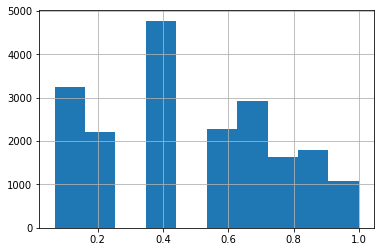

In [34]:
plays['excitement_score_v1'].hist()

<AxesSubplot:>

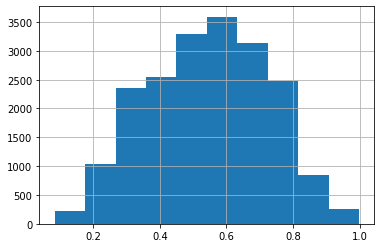

In [35]:
plays['excitement_score_v2'].hist()

It looks like the metric has a normal distribution now, which is good (maybe)?

## Excitement V3

Let's add 2 new factors to excitement score: **time_left_in_half** and **quarter**. We'll just do a linear score for both of these where we assume plays are more exciting at the end of the half and in later quarters.

$$
\text{excitement_score_v3} = 0.25 * ((1 - p_r) + \text{score_diff_ex} + \frac{\text{quarter}}{5} + \text{time_left_in_half})
$$

In [36]:
plays.loc[plays['quarter']==5, 'gameClock'].describe()

count          102
unique          61
top       10:00:00
freq            34
Name: gameClock, dtype: object

In [37]:
seconds_in_a_half = 15 * 60
seconds_in_overtime = 10 * 60

plays['gameClockMins'] = plays['gameClock'].str.split(':').str[0]
plays['gameClockSecs'] = plays['gameClock'].str.split(':').str[1]
plays['seconds_left_in_quarter'] = plays['gameClockMins'].astype(int) * 60 + plays['gameClockSecs'].astype(int)
plays.loc[plays['quarter'].isin([2, 4, 5]), 'seconds_left_in_half'] = plays['seconds_left_in_quarter']
plays.loc[plays['quarter'].isin([1, 3]), 'seconds_left_in_half'] = plays['seconds_left_in_quarter'] + seconds_in_a_half
plays.head()

,gameId,playId,playDescription,quarter,down,yardsToGo,possessionTeam,specialTeamsPlayType,specialTeamsResult,kickerId,...,visitorTeamAbbr,is_home_offense,excitement_score_v1,score_diff,score_diff_ex,excitement_score_v2,gameClockMins,gameClockSecs,seconds_left_in_quarter,seconds_left_in_half
0,2018090600,37,J.Elliott kicks 65 yards from PHI 35 to end zo...,1,0,0,PHI,Kickoff,Touchback,44966.0,...,ATL,True,0.391432,0.0,0.9,0.645716,15,00,900,1800.0
1,2018090600,366,"(9:20) C.Johnston punts 56 yards to ATL 36, Ce...",1,4,4,PHI,Punt,Return,45603.0,...,ATL,True,0.618428,0.0,0.9,0.759214,09,20,560,1460.0
2,2018090600,658,"(5:03) M.Bryant 21 yard field goal is GOOD, Ce...",1,4,3,ATL,Field Goal,Kick Attempt Good,27091.0,...,ATL,False,0.165224,0.0,0.9,0.532612,05,03,303,1203.0
3,2018090600,677,M.Bosher kicks 64 yards from ATL 35 to PHI 1. ...,1,0,0,ATL,Kickoff,Return,37267.0,...,ATL,False,0.627566,3.0,0.8,0.713783,05,01,301,1201.0
4,2018090600,872,"(:33) C.Johnston punts 65 yards to end zone, C...",1,4,18,PHI,Punt,Touchback,45603.0,...,ATL,True,0.936071,-3.0,0.8,0.868035,00,33,33,933.0


In [38]:
plays.loc[plays['quarter'] != 5, 'time_left_ex'] = (1 - plays['seconds_left_in_half'] / (seconds_in_a_half * 2))
plays.loc[plays['quarter'] == 5, 'time_left_ex'] = (1 - plays['seconds_left_in_half'] / seconds_in_overtime)

In [39]:
plays['quarter_ex'] = plays['quarter'] / 5

In [40]:
plays['excitement_score_v3'] = 0.25 * (plays['excitement_score_v1'] + plays['score_diff_ex'] + plays['quarter_ex'] + plays['time_left_ex'])

In [41]:
top_3_plays_v3 = plays.sort_values('excitement_score_v3', ascending=False).head(3)
top_3_plays_v3

,gameId,playId,playDescription,quarter,down,yardsToGo,possessionTeam,specialTeamsPlayType,specialTeamsResult,kickerId,...,score_diff,score_diff_ex,excitement_score_v2,gameClockMins,gameClockSecs,seconds_left_in_quarter,seconds_left_in_half,time_left_ex,quarter_ex,excitement_score_v3
91,2018090901,5480,(:13) Z.Gonzalez 43 yard field goal is BLOCKED...,5,3,11,CLE,Field Goal,Blocked Kick Attempt,45037.0,...,0.0,0.9,0.943037,00,13,13,13.0,0.978333,1.0,0.966102
19860,2021010311,4695,(:09) B.McManus 63 yard field goal is BLOCKED ...,4,2,5,DEN,Field Goal,Blocked Kick Attempt,40276.0,...,-1.0,1.0,0.993037,00,09,9,9.0,0.995000,0.8,0.945269
481,2018091602,4709,"(:04) D.Carlson 35 yard field goal is No Good,...",5,1,10,MIN,Field Goal,Kick Attempt No Good,46236.0,...,0.0,0.9,0.877362,00,04,4,4.0,0.993333,1.0,0.937014


In [42]:
cols = [
    'gameId', 
    'playId', 
    'excitement_score_v1', 
    'excitement_score_v2', 
    'excitement_score_v3', 
    'specialTeamsPlayType',
    'specialTeamsResult', 
    'preSnapHomeScore', 
    'preSnapVisitorScore'
]

for game_id, play_id, ex1, ex2, ex3, play_type, result, hs, vs in top_3_plays_v3[cols].values:
    print(f'Game: {game_id}; '+ 
          f'Play: {play_id}; ' + 
          f'Excitement Score V1: {ex1}; ' + 
          f'Excitement Score V2: {ex2}; ' + 
          f'Excitement Score V3: {ex3}; ' + 
          f'PlayType: {play_type}; '+
          f'Result: {result}; '+
          f'HomeScore: {hs}; '+
          f'VisitorScore: {vs}'
    )
    # animate_play(game_id, play_id, std=True)

Game: 2018090901; Play: 5480; Excitement Score V1: 0.9860745201354911; Excitement Score V2: 0.9430372600677456; Excitement Score V3: 0.9661019633672061; PlayType: Field Goal; Result: Blocked Kick Attempt; HomeScore: 21; VisitorScore: 21
Game: 2021010311; Play: 4695; Excitement Score V1: 0.9860745201354911; Excitement Score V2: 0.9930372600677455; Excitement Score V3: 0.9452686300338728; PlayType: Field Goal; Result: Blocked Kick Attempt; HomeScore: 31; VisitorScore: 32
Game: 2018091602; Play: 4709; Excitement Score V1: 0.8547233722243132; Excitement Score V2: 0.8773616861121566; Excitement Score V3: 0.9370141763894115; PlayType: Field Goal; Result: Kick Attempt No Good; HomeScore: 29; VisitorScore: 29


<AxesSubplot:>

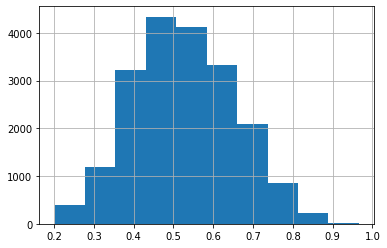

In [43]:
plays['excitement_score_v3'].hist()

## Attempt to Predict Excitement Score In-Play

As of `excitement_score_v3`, there's only 1 factor that depends on what actually happens during the play- `specialTeamsResult`. So, we'll equally weight the other three factors to have the excitement score for Frame 1 of each play. Then we'll update the score based on the expected play result for each frame, as well as how much the expected result has changed during the play. 

This is where I'm not as confident in what we need to do, but I think we need to:

1. Focus on just 1 type of special teams play
    - We'll start with **Kickoffs** just because it has the most plays
    - Eventually there will either be 4 models (1 for each play type) or 1 model that can handle all the play types
1. One hot encode playResult
1. Merge play result with tracking data
1. Decide inputs and reformat data
    - This is hopefully going to change later on
    - Convert cartesian -> polar
        - I don't know if there's a better spot to have the origin, so we'll just use (0, 0)
        - We do this when we import tracking data now :)
    - To start it'll just be an array of:
        - player polar coordinates
        - ball polar coordinates
        - Maybe yardline
    - All of these should be standardized (especially if yardline is included)
1. Train/test split
1. Design model

In [44]:
kickoffs = plays[plays['specialTeamsPlayType']=='Kickoff'].reset_index(drop=True)

print(f'Number of Kickoff games: {len(kickoffs.index)}')

Number of Kickoff games: 7843


In [45]:
encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)
transformed = encoder.fit_transform(kickoffs[['specialTeamsResult']])
output_cols = [x.split('_')[1] for x in encoder.get_feature_names()]
ohe_df = pd.DataFrame(transformed, columns=output_cols)
kickoffs = pd.concat([kickoffs, ohe_df], axis=1)
kickoffs.head()

,gameId,playId,playDescription,quarter,down,yardsToGo,possessionTeam,specialTeamsPlayType,specialTeamsResult,kickerId,...,time_left_ex,quarter_ex,excitement_score_v3,Downed,Fair Catch,Kickoff Team Recovery,Muffed,Out of Bounds,Return,Touchback
0,2018090600,37,J.Elliott kicks 65 yards from PHI 35 to end zo...,1,0,0,PHI,Kickoff,Touchback,44966.0,...,0.000000,0.2,0.372858,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,2018090600,677,M.Bosher kicks 64 yards from ATL 35 to PHI 1. ...,1,0,0,ATL,Kickoff,Return,37267.0,...,0.332778,0.2,0.490086,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,2018090600,1387,J.Elliott kicks 65 yards from PHI 35 to end zo...,2,0,0,PHI,Kickoff,Touchback,44966.0,...,0.795000,0.4,0.621608,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,2018090600,1606,M.Bosher kicks 68 yards from ATL 35 to PHI -3....,2,0,0,ATL,Kickoff,Return,37267.0,...,0.928889,0.4,0.689114,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,2018090600,2225,M.Bosher kicks 65 yards from ATL 35 to end zon...,3,0,0,ATL,Kickoff,Touchback,37267.0,...,0.000000,0.6,0.447858,0.0,0.0,0.0,0.0,0.0,0.0,1.0


Next, we'll create the initial excitement for each play. This will be the same for all frames and we'll update this score after each frame based on how the model predicts the outcome of each play.

In [46]:
kickoffs['initial_excitement'] = 1/3 * (kickoffs['score_diff_ex'] + kickoffs['quarter_ex'] + kickoffs['time_left_ex'])

Now we have to merge play data with tracking data. *Warning: This takes a couple of minutes.*

In [47]:
kickoff_tracking = kickoffs.merge(tracking, on=['gameId', 'playId'])

In [48]:
kickoff_tracking.columns

Index(['gameId', 'playId', 'playDescription', 'quarter', 'down', 'yardsToGo',
       'possessionTeam', 'specialTeamsPlayType', 'specialTeamsResult',
       'kickerId', 'returnerId', 'kickBlockerId', 'yardlineSide',
       'yardlineNumber', 'gameClock', 'penaltyCodes', 'penaltyJerseyNumbers',
       'penaltyYards', 'preSnapHomeScore', 'preSnapVisitorScore', 'passResult',
       'kickLength', 'kickReturnYardage', 'playResult',
       'absoluteYardlineNumber', 'season', 'week', 'gameDate',
       'gameTimeEastern', 'homeTeamAbbr', 'visitorTeamAbbr', 'is_home_offense',
       'excitement_score_v1', 'score_diff', 'score_diff_ex',
       'excitement_score_v2', 'gameClockMins', 'gameClockSecs',
       'seconds_left_in_quarter', 'seconds_left_in_half', 'time_left_ex',
       'quarter_ex', 'excitement_score_v3', 'Downed', 'Fair Catch',
       'Kickoff Team Recovery', 'Muffed', 'Out of Bounds', 'Return',
       'Touchback', 'initial_excitement', 'time', 'x', 'y', 's', 'a', 'dis',
       'o', 'di

We'll create a new column now that we combined play and tracking data that will indicate if a player is on **offense** or **defense** during a play and apply that to all frames of that play. We'll consider the ball as **offense**. Let's call this column `is_off`. We need this column to help order the data for our model, but we'll talk more about that later.

In [49]:
kickoff_tracking['is_off'] = (kickoff_tracking['is_home_offense'] & (kickoff_tracking['team'] == 'home')) | (~kickoff_tracking['is_home_offense'] & (kickoff_tracking['team'] == 'away')) | (kickoff_tracking['team'] == 'football')
kickoff_tracking.head()

,gameId,playId,playDescription,quarter,down,yardsToGo,possessionTeam,specialTeamsPlayType,specialTeamsResult,kickerId,...,position,team,frameId,playDirection,stdX,stdY,stdDir,stdR,stdTheta,is_off
0,2018090600,37,J.Elliott kicks 65 yards from PHI 35 to end zo...,1,0,0,PHI,Kickoff,Touchback,44966.0,...,FS,home,1,right,43.76,8.10,53.28,44.503344,0.183029,True
1,2018090600,37,J.Elliott kicks 65 yards from PHI 35 to end zo...,1,0,0,PHI,Kickoff,Touchback,44966.0,...,FS,home,2,right,43.77,8.10,73.05,44.513177,0.182988,True
2,2018090600,37,J.Elliott kicks 65 yards from PHI 35 to end zo...,1,0,0,PHI,Kickoff,Touchback,44966.0,...,FS,home,3,right,43.78,8.10,70.39,44.523010,0.182947,True
3,2018090600,37,J.Elliott kicks 65 yards from PHI 35 to end zo...,1,0,0,PHI,Kickoff,Touchback,44966.0,...,FS,home,4,right,43.80,8.11,71.53,44.544496,0.183086,True
4,2018090600,37,J.Elliott kicks 65 yards from PHI 35 to end zo...,1,0,0,PHI,Kickoff,Touchback,44966.0,...,FS,home,5,right,43.84,8.12,75.17,44.585648,0.183143,True


Cool, now we have all the fields we need to create a model that predicts the result of the frame: 

- stdR for each player (and the ball)
- stdTheta for each player (and the ball) 
- If a player is on offense or defense
- And the outcome of the play

So let's begin processing and shaping the data in a suitable way for a model. Checklist:

1. Scale `stdR` and `stdTheta` to be between 0 and 1
1. Combine position data for the same frame and sort it by ball first, then increasing nflId for offensive team then defense
    - Hopefully this will create some augmentation that will prevent the model from overfitting.
1. Merge the OHE outcome of each play with each frame for that play.
1. Convert into input/output 2D arrays
1. Split into training and testing sets

In [50]:
features = ['stdR', 'stdTheta']

sc = MinMaxScaler()
kickoff_tracking[features] = sc.fit_transform(kickoff_tracking[features])

In [51]:
# Define how we want our data sorted
sort_cols = ['gameId', 'playId', 'frameId', 'is_off', 'nflId']

In [52]:
df = kickoff_tracking[[*sort_cols, *features]].set_index(sort_cols).sort_index(level=sort_cols).droplevel('nflId')
df = df.set_index(df.groupby(['gameId', 'playId', 'frameId']).cumcount().rename('playerNum'), append=True)
df = df[features].unstack(['is_off', 'playerNum']).reset_index(['gameId', 'playId', 'frameId'])

df.head()

gameId playId frameId      stdR                                \
is_off                                   False                                 
playerNum                                    0         1         2         3   
0          2018090600     37       1  0.553096  0.522896  0.480649  0.660584   
1          2018090600     37       2  0.553035  0.522996  0.480588  0.660573   
2          2018090600     37       3  0.553071  0.523095  0.480588  0.660503   
3          2018090600     37       4  0.553071  0.523151  0.480611  0.660573   
4          2018090600     37       5  0.553071  0.523306  0.480671  0.660584   

                                         ...  stdTheta                      \
is_off                                   ...      True                       
playerNum         4         5         6  ...        13        14        15   
0          0.683967  0.480869  0.439862  ...  0.329865  0.680000  0.468614   
1          0.683939  0.480799  0.439796  ...  0.329646  0.680000  0.468796   
2          0.683939  0.480812  0.439769  ...  0.329533  0.679953  0.468796   
3          0.683910  0.480812  0.439769  ...  0.329524  0.679900  0.468886   
4          0.683910  0.480743  0.439769  ...  0.329515  0.679900  0.469105   

                                                                       \
is_off                                                                  
playerNum        16        17        18        19        20        21   
0          0.611685  0.508762  0.586472  0.583543  0.426882  0.631340   
1          0.611403  0.508847  0.583207  0.583510  0.426980  0.631282   
2          0.611184  0.508931  0.579726  0.583340  0.427077  0.631229   
3          0.611194  0.509016  0.576015  0.583290  0.427145  0.631176   
4          0.611268  0.509100  0.572099  0.583000  0.427378  0.631069   

                     
is_off               
playerNum        22  
0          0.658324  
1          0.658429  
2          0.658587  
3          0.658798  
4          0.658956  

[5 rows x 49 columns]

In [53]:
# Get the result of each play
results = kickoff_tracking.groupby(['gameId', 'playId', 'frameId'])[output_cols].first()

results.head()

Downed  Fair Catch  Kickoff Team Recovery  Muffed  \
gameId     playId frameId                                                      
2018090600 37     1           0.0         0.0                    0.0     0.0   
                  2           0.0         0.0                    0.0     0.0   
                  3           0.0         0.0                    0.0     0.0   
                  4           0.0         0.0                    0.0     0.0   
                  5           0.0         0.0                    0.0     0.0   

                           Out of Bounds  Return  Touchback  
gameId     playId frameId                                    
2018090600 37     1                  0.0     0.0        1.0  
                  2                  0.0     0.0        1.0  
                  3                  0.0     0.0        1.0  
                  4                  0.0     0.0        1.0  
                  5                  0.0     0.0        1.0

In [54]:
# Join the data sorted for each frame with the play result
df = df.join(results, on=['gameId', 'playId', 'frameId'])

# Rename columns for readability
df.columns = ['_'.join(str(i) for i in x if i != '') if type(x) == tuple else x for x in df.columns]

df.head()

,gameId,playId,frameId,stdR_False_0,stdR_False_1,stdR_False_2,stdR_False_3,stdR_False_4,stdR_False_5,stdR_False_6,...,stdTheta_True_20,stdTheta_True_21,stdTheta_True_22,Downed,Fair Catch,Kickoff Team Recovery,Muffed,Out of Bounds,Return,Touchback
0,2018090600,37,1,0.553096,0.522896,0.480649,0.660584,0.683967,0.480869,0.439862,...,0.426882,0.631340,0.658324,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,2018090600,37,2,0.553035,0.522996,0.480588,0.660573,0.683939,0.480799,0.439796,...,0.426980,0.631282,0.658429,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,2018090600,37,3,0.553071,0.523095,0.480588,0.660503,0.683939,0.480812,0.439769,...,0.427077,0.631229,0.658587,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,2018090600,37,4,0.553071,0.523151,0.480611,0.660573,0.683910,0.480812,0.439769,...,0.427145,0.631176,0.658798,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,2018090600,37,5,0.553071,0.523306,0.480671,0.660584,0.683910,0.480743,0.439769,...,0.427378,0.631069,0.658956,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [55]:
# Convert to array
values = df.values
print(values.shape)
print(values[0])

(618098, 56)
[2.01809060e+09 3.70000000e+01 1.00000000e+00 5.53095559e-01
 5.22896344e-01 4.80648535e-01 6.60584415e-01 6.83967252e-01
 4.80868708e-01 4.39861895e-01 5.16338284e-01 7.95061811e-01
 4.08953143e-01 4.21182966e-01 3.56200050e-01 2.99571912e-01
 2.96243873e-01 4.48049165e-01 3.19173744e-01 3.86027982e-01
 3.30171198e-01 3.44803820e-01 3.67992180e-01 3.05836510e-01
 3.99778786e-01 4.26450259e-01 5.37624925e-01 6.02738911e-01
 5.48160466e-01 3.67949691e-01 4.81729350e-01 3.75553518e-01
 4.70716375e-01 4.74209721e-01 4.00768151e-01 3.56011607e-01
 4.11065449e-01 5.38590477e-01 3.74742907e-01 3.29865065e-01
 6.79999898e-01 4.68614001e-01 6.11685385e-01 5.08762379e-01
 5.86472143e-01 5.83542745e-01 4.26881952e-01 6.31340218e-01
 6.58323573e-01 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 1.00000000e+00]


Input for the model should only be 46 values- the first 3 columns in `values` are: `gameId`, `playId`, `frameId`. The last 7 columns are the encoded `playResult` values. We'll drop the first 3 columns for now, but potentially may want them later if we need them for an RNN.

In [56]:
x = np.array([x[3:-7] for x in values])
print(x.shape)
print(x[0])

(618098, 46)
[0.55309556 0.52289634 0.48064853 0.66058442 0.68396725 0.48086871
 0.43986189 0.51633828 0.79506181 0.40895314 0.42118297 0.35620005
 0.29957191 0.29624387 0.44804917 0.31917374 0.38602798 0.3301712
 0.34480382 0.36799218 0.30583651 0.39977879 0.42645026 0.53762492
 0.60273891 0.54816047 0.36794969 0.48172935 0.37555352 0.47071637
 0.47420972 0.40076815 0.35601161 0.41106545 0.53859048 0.37474291
 0.32986506 0.6799999  0.468614   0.61168538 0.50876238 0.58647214
 0.58354274 0.42688195 0.63134022 0.65832357]


In [57]:
y = np.array([x[-7:] for x in values])
print(y.shape)
print(y[0])

(618098, 7)
[0. 0. 0. 0. 0. 0. 1.]


In [58]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state=1, shuffle=False)

Great, we can now start designing the model. Let's try a very simple approach and use a sequential model with 1 hidden layer that has 92 hidden nodes (just double the input nodes). 

> This is just a random number of nodes. Also, I'm not sure about loss functions/optimizers/activations.

In [59]:
num_input_nodes = x.shape[1]
num_hidden_nodes = x.shape[1] * 2
num_output_nodes = y.shape[1]

model = Sequential()
model.add(Dense(num_hidden_nodes, input_dim=num_input_nodes, activation='relu'))
model.add(Dense(num_output_nodes, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

2021-10-20 20:23:39.282344: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Now we can train the model using our training dataset.

In [60]:
model.fit(x_train, y_train, epochs=3, verbose=1)

2021-10-20 20:23:40.023491: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
Epoch 1/3
12942/12942 [==============================] - 13s 944us/step - loss: 0.5805 - accuracy: 0.7314
Epoch 2/3
12942/12942 [==============================] - 12s 943us/step - loss: 0.5056 - accuracy: 0.7779
Epoch 3/3
12942/12942 [==============================] - 12s 963us/step - loss: 0.4785 - accuracy: 0.7912


We'll evaluate on the test set and see the loss and accuracy.

In [61]:
results = model.evaluate(x_test, y_test)
print(f'Loss: {results[0]}; Accuracy: {results[1]}')

6375/6375 [==============================] - 5s 689us/step - loss: 0.4624 - accuracy: 0.7974
Loss: 0.462412565946579; Accuracy: 0.7973555326461792


Let's take a look at how well the model predicted 10 frames from our test set.

In [62]:
y_pred = model.predict(x_test)
for pred, actual in zip(y_pred[:10], y_test[:10]):
	print(f'Pred: {pred}; Actual: {actual}')

Pred: [0.         0.00001596 0.00000019 0.00529703 0.00244545 0.1202009
 0.87204045]; Actual: [0. 0. 0. 0. 0. 0. 1.]
Pred: [0.         0.00001515 0.00000018 0.00535309 0.0024524  0.11933786
 0.8728413 ]; Actual: [0. 0. 0. 0. 0. 0. 1.]
Pred: [0.         0.00001444 0.00000017 0.00541366 0.00246741 0.11827125
 0.87383306]; Actual: [0. 0. 0. 0. 0. 0. 1.]
Pred: [0.         0.00001445 0.00000017 0.00565701 0.00253136 0.12212253
 0.8696745 ]; Actual: [0. 0. 0. 0. 0. 0. 1.]
Pred: [0.         0.00001456 0.00000017 0.00593749 0.00261271 0.12656274
 0.86487234]; Actual: [0. 0. 0. 0. 0. 0. 1.]
Pred: [0.         0.00001488 0.00000017 0.00629331 0.00271189 0.1327842
 0.85819554]; Actual: [0. 0. 0. 0. 0. 0. 1.]
Pred: [0.         0.00001549 0.00000018 0.00672814 0.00284637 0.1404575
 0.84995234]; Actual: [0. 0. 0. 0. 0. 0. 1.]
Pred: [0.         0.00001449 0.00000018 0.00702499 0.00290361 0.14160714
 0.84844965]; Actual: [0. 0. 0. 0. 0. 0. 1.]
Pred: [0.         0.0000062  0.00000014 0.00598697 0.002337

And we'll take a look at the confusion matrix to see if anything is super alarming. But first, we have to filter out the play results that aren't in the test set, in order for the confusion matrix to work.

In [63]:
indexes = np.unique(y_test.argmax(axis=1))
play_results_in_y_true = [x for i, x in enumerate(output_cols)if i in indexes]
play_results_in_y_true

['Downed',
 'Kickoff Team Recovery',
 'Muffed',
 'Out of Bounds',
 'Return',
 'Touchback']

<AxesSubplot:>

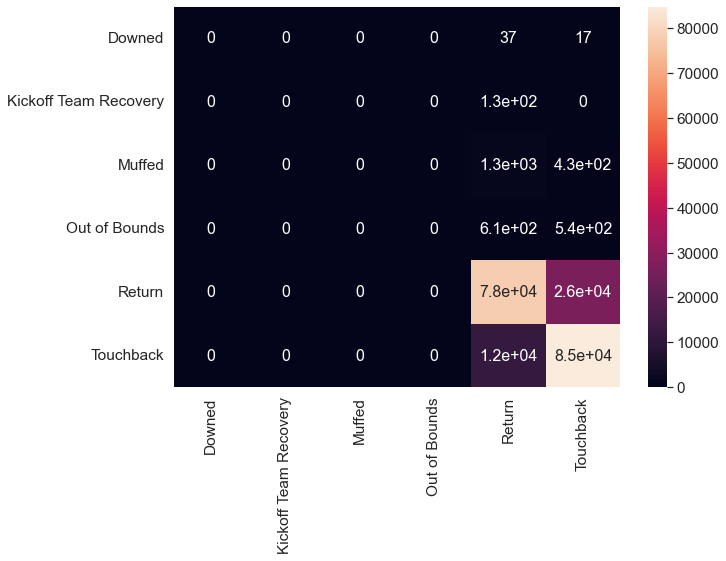

In [64]:
matrix = confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))
df_cm = pd.DataFrame(matrix, play_results_in_y_true, play_results_in_y_true)

plt.figure(figsize=(10,7))
sn.set(font_scale=1.4)
sn.heatmap(df_cm, annot=True, annot_kws={"size": 16})

Now, let's investigate one play from the test set to see if:

1. The predictions change from frame to frame
1. The predictions converge to the actual result by the final frame

In [65]:
games_and_plays = list(df.groupby(['gameId', 'playId']).groups.keys())

In [66]:
final_game_id = games_and_plays[-1][0]
final_play_id = games_and_plays[-1][1]
final_play = df.loc[(df['gameId']==final_game_id) & (df['playId']==final_play_id)]
final_play_x = np.array([frame[3:-7] for frame in final_play.values])
final_play_y = np.array([frame[-7:] for frame in final_play.values])
final_play_preds = model.predict(final_play_x)

In [67]:
analysis = pd.DataFrame(final_play_preds, index=final_play['frameId'], columns=output_cols)
analysis

,Downed,Fair Catch,Kickoff Team Recovery,Muffed,Out of Bounds,Return,Touchback
frameId,,,,,,,
1,0.006519,0.004056,0.003489,0.039279,0.036645,0.794502,0.115510
2,0.006507,0.004058,0.003492,0.039270,0.036732,0.794265,0.115676
3,0.006475,0.004055,0.003483,0.039243,0.036802,0.793908,0.116035
4,0.006452,0.004056,0.003480,0.039231,0.036898,0.793592,0.116291
5,0.006426,0.004056,0.003472,0.039231,0.036996,0.793189,0.116630
6,0.006389,0.004052,0.003467,0.039200,0.037155,0.792669,0.117068
7,0.006321,0.004039,0.003455,0.039136,0.037419,0.791818,0.117811
8,0.006241,0.004025,0.003441,0.039058,0.037823,0.790702,0.118709
9,0.006125,0.003997,0.003414,0.038945,0.038399,0.788990,0.120129


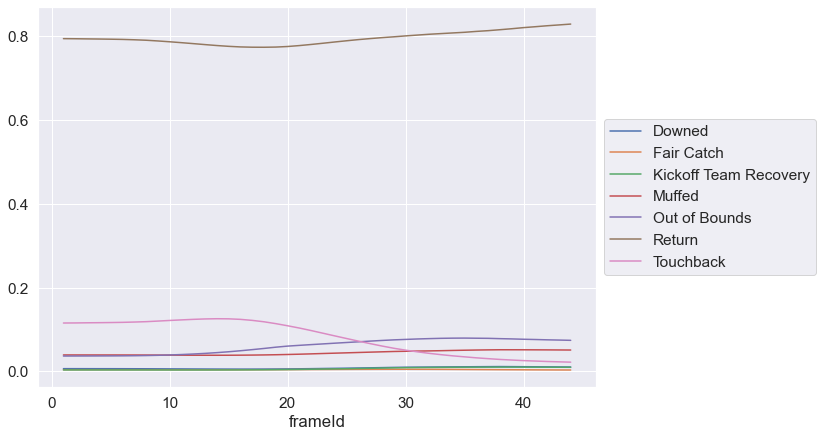

In [68]:
analysis.plot.line(y=output_cols, figsize=(10,7)).legend(loc='center left',bbox_to_anchor=(1.0, 0.5))

Now let's see what the excitement score based on just the predicted outcome of the play would look like throughout the play.

In [69]:
kickoff_outcome_probs = excitement_scores.transpose()['Kickoff'].loc['excitement_score_v1']
analysis['excitement'] = analysis.mul(kickoff_outcome_probs, axis=1).sum(axis=1)
analysis['excitement']

frameId
1     0.633192
2     0.633179
3     0.633093
4     0.633054
5     0.632997
6     0.632923
7     0.632786
8     0.632653
9     0.632422
10    0.632258
11    0.632212
12    0.632274
13    0.632528
14    0.633027
15    0.633874
16    0.635143
17    0.636852
18    0.638916
19    0.641418
20    0.643984
21    0.646448
22    0.649086
23    0.651848
24    0.654587
25    0.657300
26    0.660036
27    0.662741
28    0.665372
29    0.667851
30    0.669793
31    0.671468
32    0.672941
33    0.674248
34    0.675378
35    0.676242
36    0.676903
37    0.677440
38    0.677736
39    0.677723
40    0.677587
41    0.677438
42    0.677227
43    0.676987
44    0.676722
Name: excitement, dtype: float64

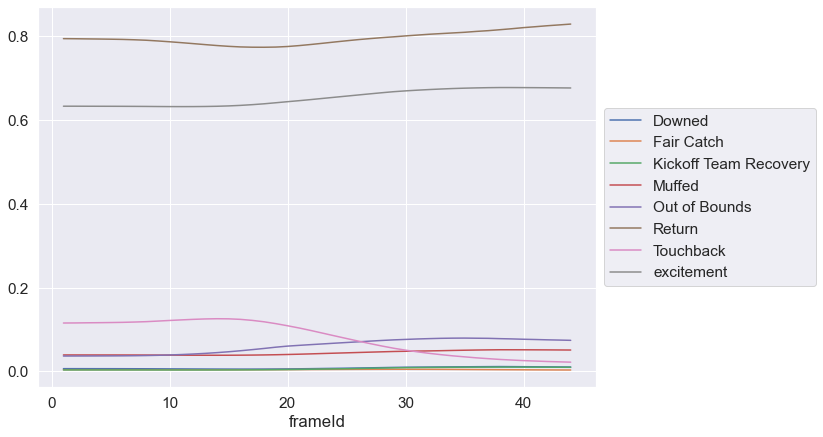

In [70]:
analysis.plot.line(figsize=(10,7)).legend(loc='center left', bbox_to_anchor=(1.0, 0.5))

Found 1012 Frames for game 2021010315 play 4182


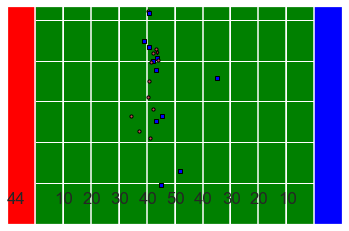

In [79]:
animate_play(final_game_id, final_play_id, True)